In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as scisig
import scipy.optimize as opt
import scipy.io as sio
import analysis_utils as au
import importlib

In [8]:
len(PSD_freq)

5001

Let's try just doing standard optimal filter assuming stationary and see how well it does

1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4


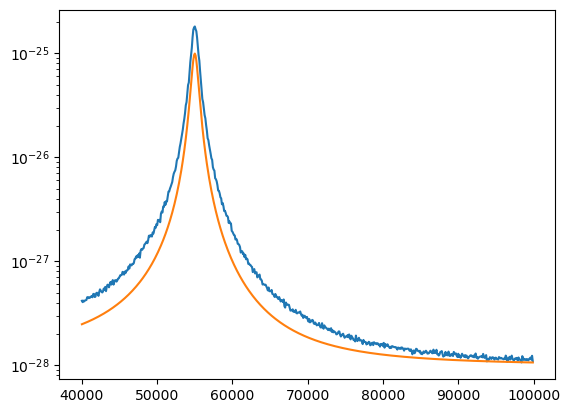

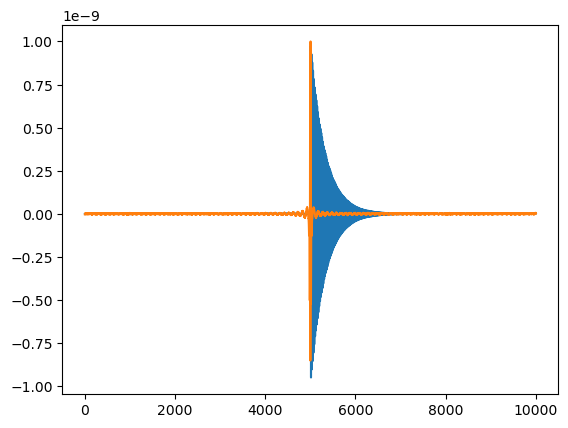

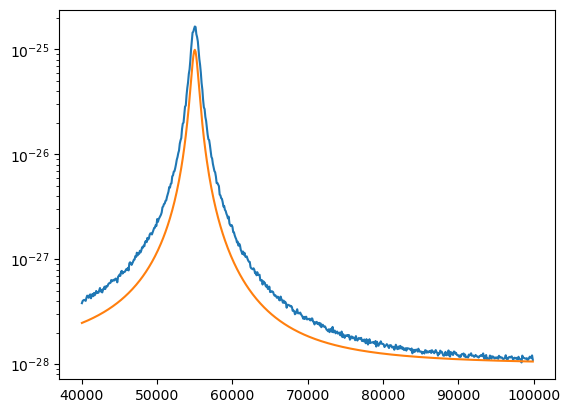

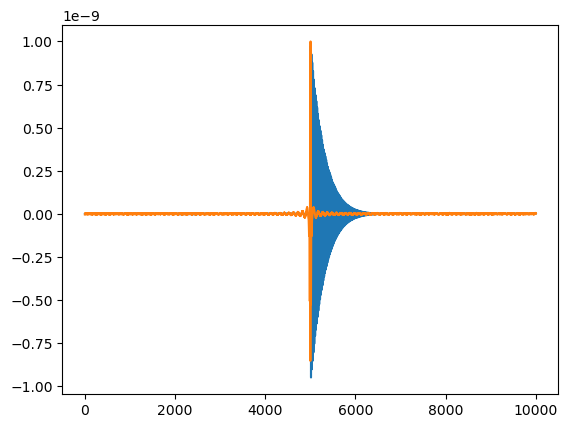

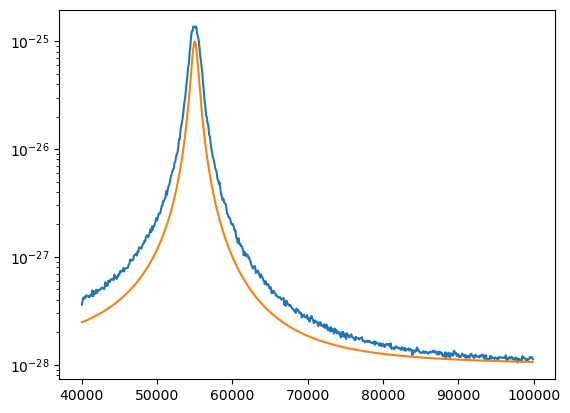

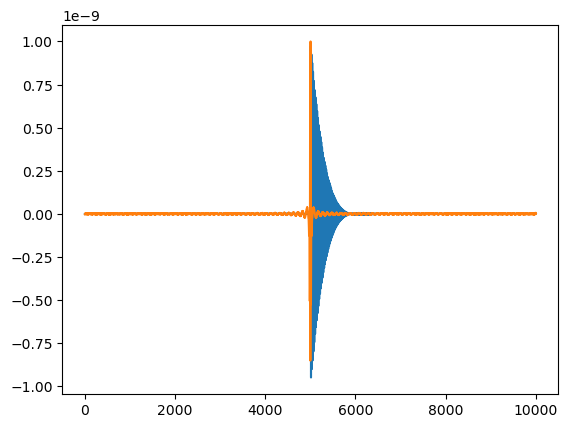

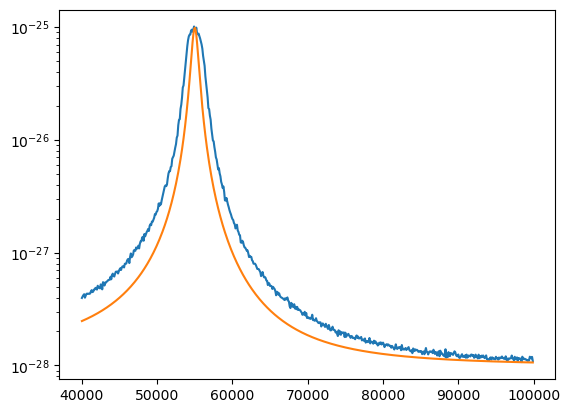

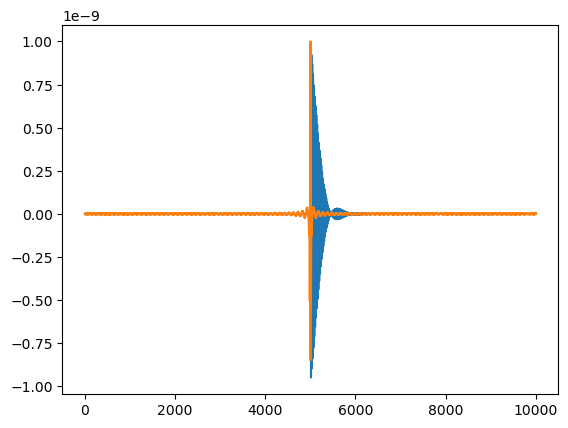

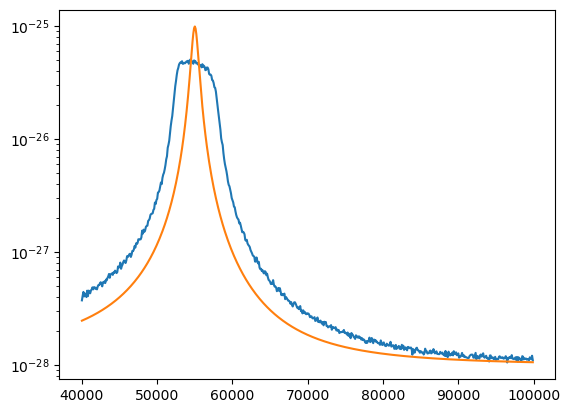

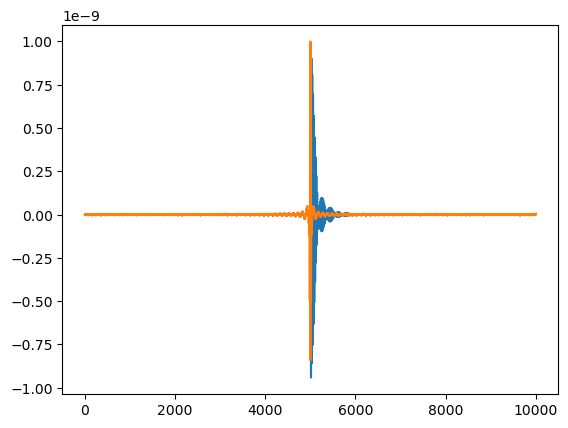

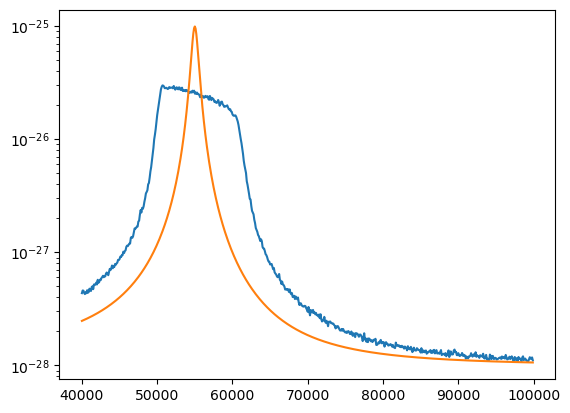

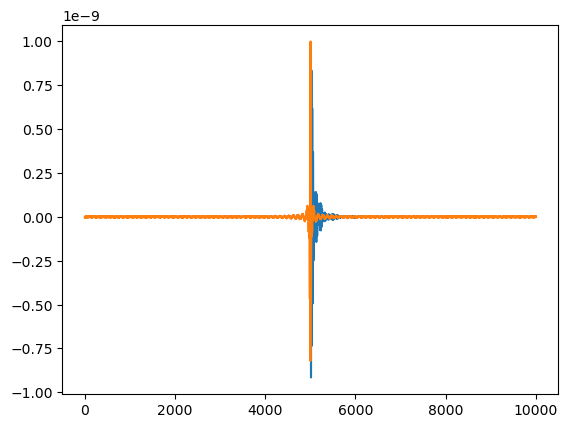

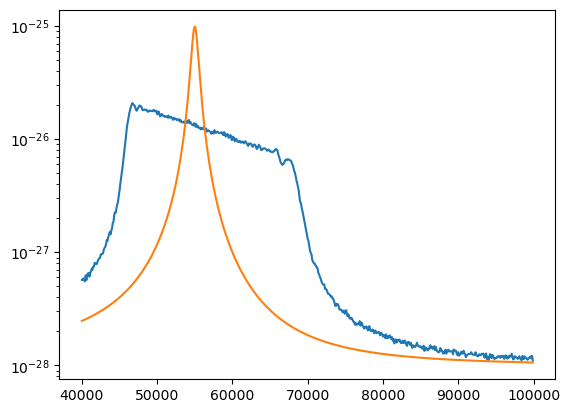

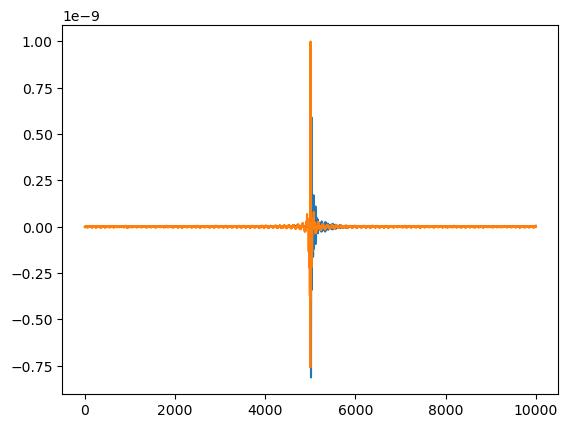

In [378]:
importlib.reload(au)

# Load in noise and response templates

filename1 ='D:/Simulation Data/240529/Frequency modulation/'

yfb_l = np.array([1000])*2*np.pi
iter_l = [0.0, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2]
for yfb in yfb_l:
    for iter in iter_l:

        numbins = int(2*5*10**4*100*2*np.pi/yfb)

        filename = 'D:/Simulation Data/240529/Frequency modulation/yfb' + str(round(yfb/2/np.pi)) + '/' + str(iter)

        data = au.load_data_hdf5(filename+'/Noise/PSD.hdf5')
        PSD_freq = data['frequency']
        PSD_noise = data['J']

        data = au.load_data_hdf5(filename+'/Kicks/avr_resp.hdf5')
        avr_resp = data['x']

        lb = 400
        ub = 1000
        plt.figure()
        plt.plot(PSD_freq[lb:ub], PSD_noise[lb:ub])
        plt.plot(PSD_freq[lb:ub], au.Linewidth2(np.array(PSD_freq[lb:ub]), 0.3*10**(-12), 55000, 1000, 10**(-28)))
        plt.yscale('log')

        plt.figure()
        plt.plot(avr_resp)

        phi_t = au.make_optimal_filter_ns(avr_resp, PSD_noise, PSD_freq)

        plt.plot(phi_t*10**(-9))

        corr_max = []
        #corr_arg = []
        #corr_data_l = np.zeros((1000, numbins))
        for i in range(1000):
            data = au.load_data_hdf5(filename+'/Kicks/' + str(i) +'.hdf5')
            x = data['x']
            cm = au.optimal_filter(phi_t, x)
            corr_max.append(cm)
        print(1)
        
        corr_max_n = []
        #corr_data_l_n = np.zeros((1000, numbins))
        np.random.seed(3716)
        for i in range(1000):
            data = au.load_data_hdf5(filename+'/Noise/' + str(i) +'.hdf5')
            x = data['x']
            cm = au.optimal_filter_noise(phi_t, x)
            corr_max_n.append(cm)
        print(2)
        cf = 55000
        BW = 30000
        amp_max = []
        for i in range(1000):
            max = au.bandpass_peak_find2(filename+'/Kicks/' + str(i) +'.hdf5', cf, BW, 10**6, 3)
            amp_max.append(max)
        
        print(3)
        
        amp_max_n = []
        for i in range(1000):
            max = au.bandpass_peak_find_noise2(filename+'/Noise/' + str(i) +'.hdf5', cf, BW, 10**6, 3)
            amp_max_n.append(max)

        print(4)
        
        analysis_dict = {'Kicks': corr_max, 'Kicks noise': corr_max_n, 'Band-pass filter': amp_max, 'Band-pass filter noise': amp_max_n}
        au.save_data_hdf5(filename1 + 'analysis' + str(int(yfb/2/np.pi)) + '_' + str(iter) +'.hdf5', analysis_dict)

Text(0, 0.5, 'Width of reconstruction (arb)')

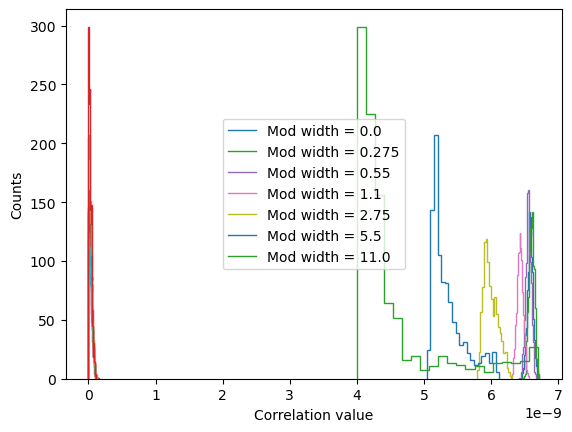

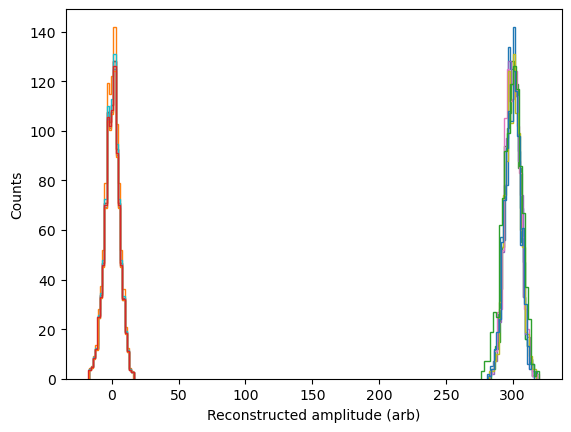

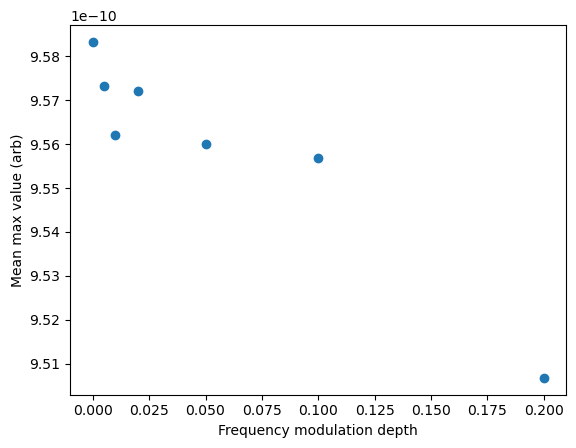

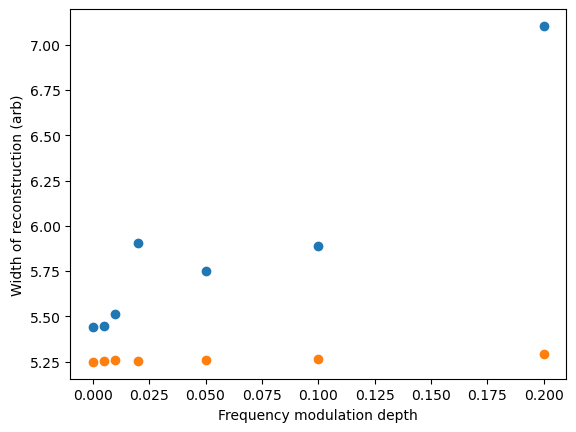

In [379]:
filename1 ='D:/Simulation Data/240529/Frequency modulation/'

yfb_l = np.array([1000])*2*np.pi
iter_l = [0.0, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2]
for yfb in yfb_l:
    for iter in iter_l:
        mdict = au.load_data_hdf5(filename1 + 'analysis' + str(int(yfb/2/np.pi)) + '_' + str(iter) +'.hdf5')

        corr_max = mdict['Kicks']
        corr_max_n = mdict['Kicks noise']
    
        hist1, bins1 = au.histogram_and_fit(corr_max, 20, 5, fit = False, plot = False)
        hist2, bins2, fit2, x_hist2, fitted2 = au.histogram_and_fit(corr_max_n, 20, 5, fit = True, plot = False)

        plt.stairs(hist1, bins1, label = 'Mod width = ' + str(iter*55000/1000))
        plt.stairs(hist2/np.max(hist2)*np.max(hist1), bins2)
 
plt.xlabel('Correlation value')
plt.ylabel('Counts') 
plt.legend()

plt.figure()

mean3_l = []
width3_l = []
width4_l = []

for yfb in yfb_l:
    for iter in iter_l:
        mdict = au.load_data_hdf5(filename1 + 'analysis' + str(int(yfb/2/np.pi)) + '_' + str(iter) +'.hdf5')

        amp_max = mdict['Band-pass filter']
        amp_max_n_max = mdict['Band-pass filter noise']
    
        hist3, bins3, fit3, x_hist3, fitted3 = au.histogram_and_fit(amp_max, 20, 5, fit = True, plot = False)
        hist4, bins4, fit4, x_hist4, fitted4 = au.histogram_and_fit(amp_max_n, 20, 5, fit = True, plot = False)
        width3_l.append(abs(fit3[2]))
        mean3_l.append(abs(fit3[1]))
        width4_l.append(abs(fit4[2]))

        plt.stairs(hist3, bins3*300/abs(fit3[1]))
        plt.stairs(hist4/np.max(hist4)*np.max(hist3), bins4*300/abs(fit3[1]))
        plt.xlabel('Reconstructed amplitude (arb)')
        plt.ylabel('Counts')

mean3_l = np.array(mean3_l)
width3_l = np.array(width3_l)
width4_l = np.array(width4_l)

plt.xlabel('Reconstructed amplitude (arb)')
plt.ylabel('Counts')

plt.figure()
plt.plot(iter_l, mean3_l, 'o')
plt.xlabel('Frequency modulation depth')
plt.ylabel('Mean max value (arb)')
plt.figure()
plt.plot(iter_l, width3_l*300/mean3_l, 'o')
plt.plot(iter_l, width4_l*300/mean3_l, 'o')
plt.xlabel('Frequency modulation depth')
plt.ylabel('Width of reconstruction (arb)')

# Just using short amount of template

In [380]:
importlib.reload(au)

# Load in noise and response templates

filename1 ='D:/Simulation Data/240529/Frequency modulation/'

yfb_l = np.array([1000])*2*np.pi
iter_l = [0.1]
bands = [5, 10, 20, 50, 100, 200, 500, 1000]
corr_max_l = []
for band in bands:
    for yfb in yfb_l:
        for iter in iter_l:

            numbins = int(2*5*10**4*100*2*np.pi/yfb)

            filename = 'D:/Simulation Data/240529/Frequency modulation/yfb' + str(round(yfb/2/np.pi)) + '/' + str(iter)

            data = au.load_data_hdf5(filename+'/Noise/PSD.hdf5')
            PSD_freq = data['frequency']
            PSD_noise = data['J']

            data = au.load_data_hdf5(filename+'/Kicks/avr_resp.hdf5')
            avr_resp = data['x']

            data = au.load_data_hdf5(filename+'/Kicks/0.hdf5')

            phi_t = au.make_optimal_filter_ns(avr_resp, PSD_noise, PSD_freq)

            corr_max = []
            #corr_arg = []
            #corr_data_l = np.zeros((1000, numbins))
            for i in range(1000):
                data = au.load_data_hdf5(filename+'/Kicks/' + str(i) +'.hdf5')
                x = data['x']
                cm = au.optimal_filter_short(phi_t, x, band)
                corr_max.append(cm)
            print(1)
            corr_max_l.append(corr_max)
            
            # corr_max_n = []
            # #corr_data_l_n = np.zeros((1000, numbins))
            # np.random.seed(3716)
            # for i in range(1000):
            #     data = au.load_data_hdf5(filename+'/Noise/' + str(i) +'.hdf5')
            #     x = data['x']
            #     cm = au.optimal_filter_noise(phi_t, x)
            #     corr_max_n.append(cm)
            # print(2)
            # cf = 55000
            # BW = 30000
            # amp_max = []
            # for i in range(1000):
            #     max = au.bandpass_peak_find2(filename+'/Kicks/' + str(i) +'.hdf5', cf, BW, 10**6, 3)
            #     amp_max.append(max)
            
            # print(3)
            
            # amp_max_n = []
            # for i in range(1000):
            #     max = au.bandpass_peak_find_noise2(filename+'/Noise/' + str(i) +'.hdf5', cf, BW, 10**6, 3)
            #     amp_max_n.append(max)

            # print(4)
            
            # analysis_dict = {'Kicks': corr_max, 'Kicks noise': corr_max_n, 'Band-pass filter': amp_max, 'Band-pass filter noise': amp_max_n}
            # au.save_data_hdf5(filename1 + 'analysis' + str(int(yfb/2/np.pi)) + '_' + str(iter) +'.hdf5', analysis_dict)

1
1
1
1
1
1
1
1


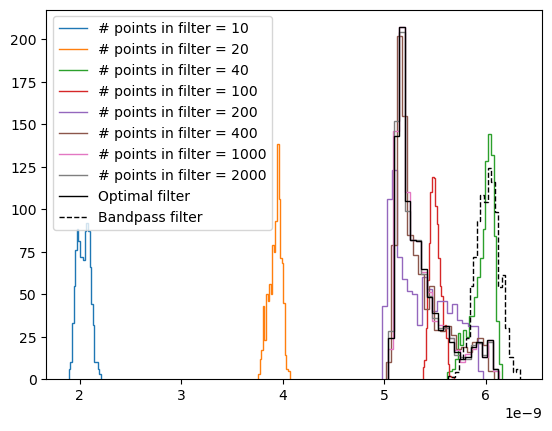

In [381]:
for n, corr_max in enumerate(corr_max_l):
    hist1, bins1 = au.histogram_and_fit(corr_max, 20, 5, fit = False, plot = False)
    plt.stairs(hist1, bins1, label = '# points in filter = ' + str(2*bands[n]))

mdict = au.load_data_hdf5(filename1 + 'analysis' + str(int(yfb/2/np.pi)) + '_' + str(iter) +'.hdf5')
corr_max2 = mdict['Kicks']
amp_max2 = mdict['Band-pass filter']

hist2, bins2= au.histogram_and_fit(corr_max2, 20, 5, fit = False, plot = False)
hist3, bins3= au.histogram_and_fit(np.array(amp_max2)*6.3, 20, 5, fit = False, plot = False)


plt.stairs(hist2, bins2, label = 'Optimal filter', color = 'k')
plt.stairs(hist3, bins3, label = 'Bandpass filter', color = 'k', linestyle = '--')
plt.legend()

In [384]:
importlib.reload(au)

# Load in noise and response templates

filename1 ='D:/Simulation Data/240529/Frequency modulation/'

yfb_l = np.array([1000])*2*np.pi
iter_l = [0.1]
bands = [55, 60, 65, 70, 75, 80, 85, 90, 95, 100]#[10, 15, 20, 25, 30, 35, 40, 45, 50]
#corr_max_l = []
for band in bands:
    for yfb in yfb_l:
        for iter in iter_l:

            numbins = int(2*5*10**4*100*2*np.pi/yfb)

            filename = 'D:/Simulation Data/240529/Frequency modulation/yfb' + str(round(yfb/2/np.pi)) + '/' + str(iter)

            data = au.load_data_hdf5(filename+'/Noise/PSD.hdf5')
            PSD_freq = data['frequency']
            PSD_noise = data['J']

            data = au.load_data_hdf5(filename+'/Kicks/avr_resp.hdf5')
            avr_resp = data['x']

            phi_t = au.make_optimal_filter_ns(avr_resp, PSD_noise, PSD_freq)

            corr_max = []
            #corr_arg = []
            #corr_data_l = np.zeros((1000, numbins))
            for i in range(1000):
                data = au.load_data_hdf5(filename+'/Kicks/' + str(i) +'.hdf5')
                x = data['x']
                cm = au.optimal_filter_short(phi_t, x, band)
                corr_max.append(cm)
            print(1)
            corr_max_l.append(corr_max)
            
            # corr_max_n = []
            # #corr_data_l_n = np.zeros((1000, numbins))
            # np.random.seed(3716)
            # for i in range(1000):
            #     data = au.load_data_hdf5(filename+'/Noise/' + str(i) +'.hdf5')
            #     x = data['x']
            #     cm = au.optimal_filter_noise(phi_t, x)
            #     corr_max_n.append(cm)
            # print(2)
            # cf = 55000
            # BW = 30000
            # amp_max = []
            # for i in range(1000):
            #     max = au.bandpass_peak_find2(filename+'/Kicks/' + str(i) +'.hdf5', cf, BW, 10**6, 3)
            #     amp_max.append(max)
            
            # print(3)
            
            # amp_max_n = []
            # for i in range(1000):
            #     max = au.bandpass_peak_find_noise2(filename+'/Noise/' + str(i) +'.hdf5', cf, BW, 10**6, 3)
            #     amp_max_n.append(max)

            # print(4)
            
            # analysis_dict = {'Kicks': corr_max, 'Kicks noise': corr_max_n, 'Band-pass filter': amp_max, 'Band-pass filter noise': amp_max_n}
            # au.save_data_hdf5(filename1 + 'analysis' + str(int(yfb/2/np.pi)) + '_' + str(iter) +'.hdf5', analysis_dict)

1
1
1
1
1
1
1
1
1
1


C:\Users\thoma\AppData\Local\Temp\ipykernel_17932\2579869729.py:14: RuntimeWarning: invalid value encountered in divide
  plt.plot(bands[:], widths*300/means, 'o')


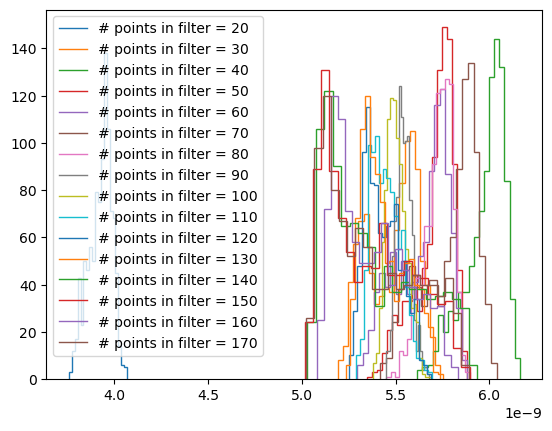

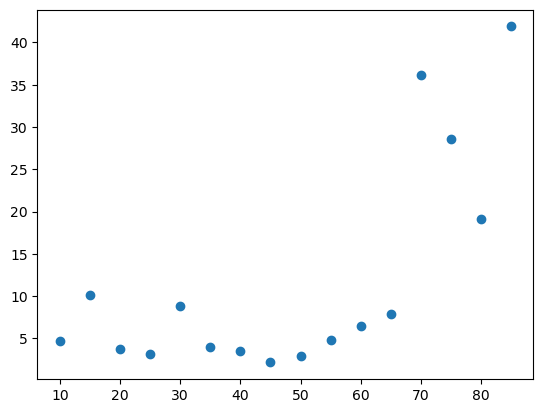

In [391]:
means = np.zeros(len(corr_max_l))
widths = np.zeros(len(corr_max_l))
bands = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
for n, corr_max in enumerate(corr_max_l[:-3]):
    hist1, bins1, fit, x_hist, fitted = au.histogram_and_fit(corr_max, 20, 5, fit = True, plot = False)
    means[n] = abs(fit[1])
    widths[n] = abs(fit[2])
    plt.stairs(hist1, bins1, label = '# points in filter = ' + str(2*bands[n]))
    #plt.plot(x_hist, fitted)

plt.legend()

plt.figure()
plt.plot(bands[:], widths*300/means, 'o')

In [ ]:
# So using like +- 40 - 50 points around the centre seems good for 0.1 modulation depth.
# Let's try a different modulation depth

In [393]:
importlib.reload(au)

# Load in noise and response templates

filename1 ='D:/Simulation Data/240529/Frequency modulation/'

yfb_l = np.array([1000])*2*np.pi
iter_l = [0.02]
bands = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
#corr_max_l = []
for band in bands:
    for yfb in yfb_l:
        for iter in iter_l:

            numbins = int(2*5*10**4*100*2*np.pi/yfb)

            filename = 'D:/Simulation Data/240529/Frequency modulation/yfb' + str(round(yfb/2/np.pi)) + '/' + str(iter)

            data = au.load_data_hdf5(filename+'/Noise/PSD.hdf5')
            PSD_freq = data['frequency']
            PSD_noise = data['J']

            data = au.load_data_hdf5(filename+'/Kicks/avr_resp.hdf5')
            avr_resp = data['x']

            phi_t = au.make_optimal_filter_ns(avr_resp, PSD_noise, PSD_freq)

            corr_max = []
            #corr_arg = []
            #corr_data_l = np.zeros((1000, numbins))
            for i in range(1000):
                data = au.load_data_hdf5(filename+'/Kicks/' + str(i) +'.hdf5')
                x = data['x']
                cm = au.optimal_filter_short(phi_t, x, band)
                corr_max.append(cm)
            print(1)
            corr_max_l.append(corr_max)
            
            # corr_max_n = []
            # #corr_data_l_n = np.zeros((1000, numbins))
            # np.random.seed(3716)
            # for i in range(1000):
            #     data = au.load_data_hdf5(filename+'/Noise/' + str(i) +'.hdf5')
            #     x = data['x']
            #     cm = au.optimal_filter_noise(phi_t, x)
            #     corr_max_n.append(cm)
            # print(2)
            # cf = 55000
            # BW = 30000
            # amp_max = []
            # for i in range(1000):
            #     max = au.bandpass_peak_find2(filename+'/Kicks/' + str(i) +'.hdf5', cf, BW, 10**6, 3)
            #     amp_max.append(max)
            
            # print(3)
            
            # amp_max_n = []
            # for i in range(1000):
            #     max = au.bandpass_peak_find_noise2(filename+'/Noise/' + str(i) +'.hdf5', cf, BW, 10**6, 3)
            #     amp_max_n.append(max)

            # print(4)
            
            # analysis_dict = {'Kicks': corr_max, 'Kicks noise': corr_max_n, 'Band-pass filter': amp_max, 'Band-pass filter noise': amp_max_n}
            # au.save_data_hdf5(filename1 + 'analysis' + str(int(yfb/2/np.pi)) + '_' + str(iter) +'.hdf5', analysis_dict)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [397]:
len(bands)

19

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


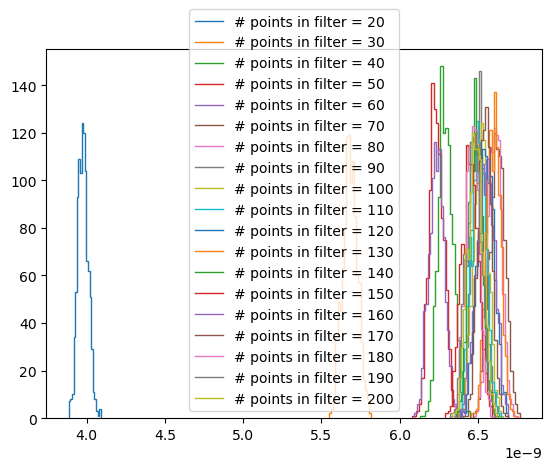

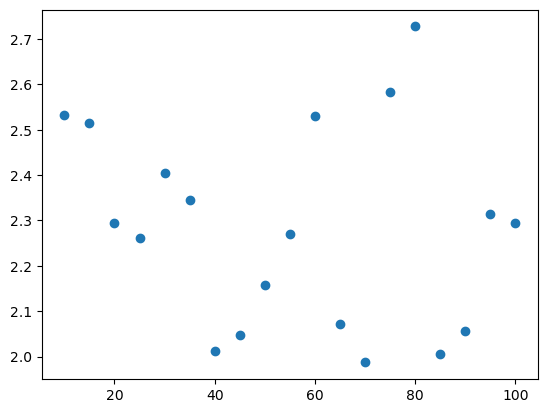

In [401]:
means = np.zeros(len(bands))
widths = np.zeros(len(bands))
bands = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
for n, corr_max in enumerate(corr_max_l[19:]):
    print(n)
    hist1, bins1, fit, x_hist, fitted = au.histogram_and_fit(corr_max, 20, 5, fit = True, plot = False)
    means[n] = abs(fit[1])
    widths[n] = abs(fit[2])
    plt.stairs(hist1, bins1, label = '# points in filter = ' + str(2*bands[n]))
    #plt.plot(x_hist, fitted)

plt.legend()

plt.figure()
plt.plot(bands[:], widths*300/means, 'o')

# Trying to measure instantaneous frequency and correct for this

In [366]:
filename = 'D:/Simulation Data/240529/Frequency modulation/yfb1000/0.2/'
data = au.load_data_hdf5(filename+'/Noise/1.hdf5')

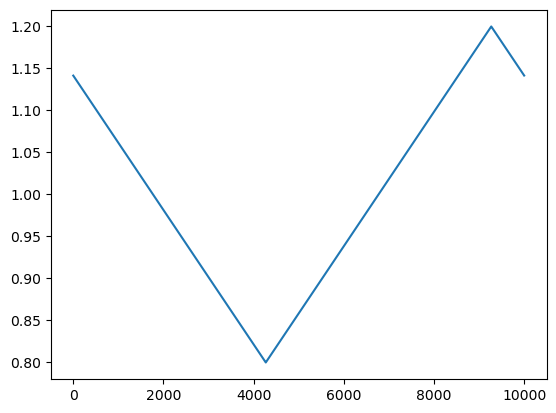

In [367]:
plt.plot(data['fm'])

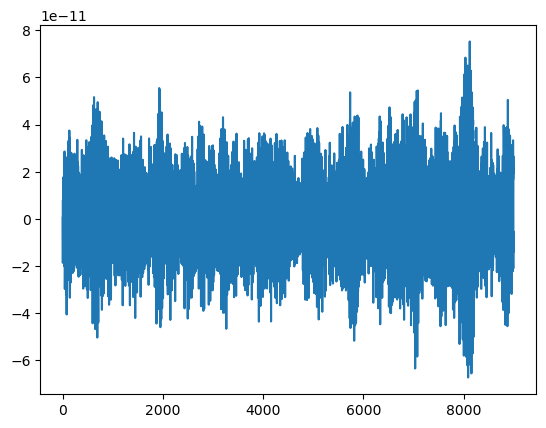

In [368]:
plt.plot(data['x'][1000:])

In [369]:
PSD = scisig.welch(data['x'], fs = 10**6, nperseg = 10**3)

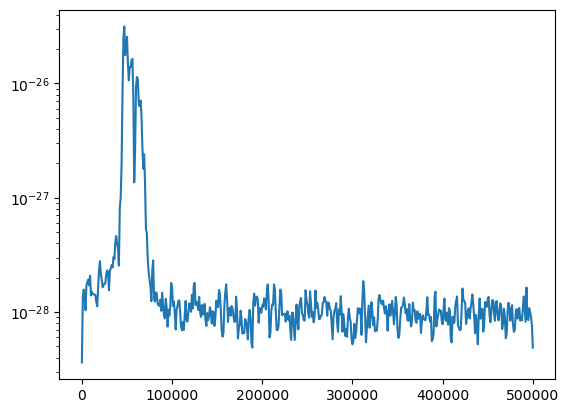

In [370]:
plt.plot(PSD[0], PSD[1])
plt.yscale('log')

In [374]:
importlib.reload(au)

time, R2, R2_filt, theta_filt = au.lockin(data['x'], fs=10**6, demod_freq=55000, BW_pre = 50000, BW = 50000, BW2 = 500, mode = 'R')

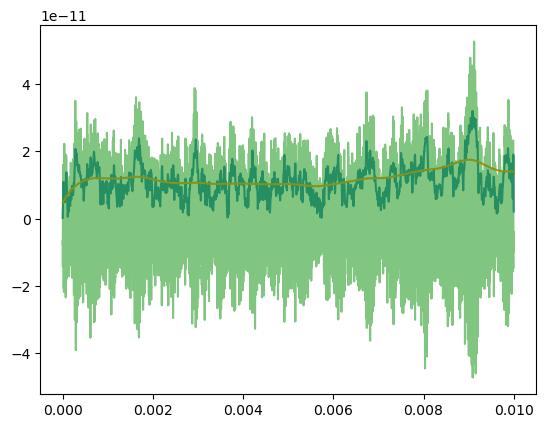

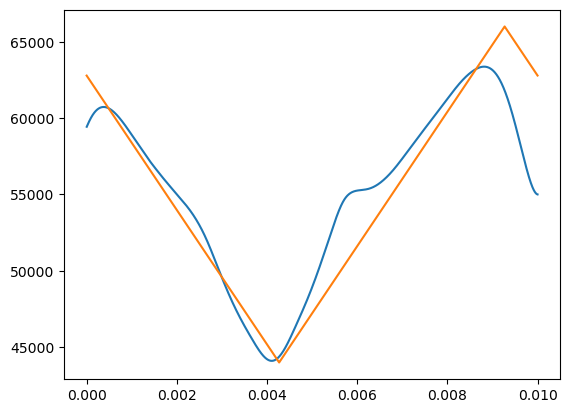

In [375]:
plt.plot(time, np.sqrt(R2))
plt.plot(time, np.sqrt(R2_filt))
plt.plot(time, np.array(data['x'])*0.7, alpha = 0.6)
plt.figure()
plt.plot(time[2:], 55000+(theta_filt[1:]-theta_filt[:-1])*10**6/2/np.pi)
plt.plot(time, np.array(data['fm'])*55000)

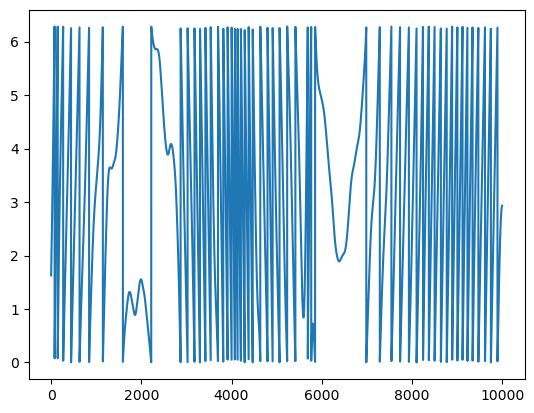

In [373]:
plt.plot(theta_filt%(2*np.pi))